# Hash Collisions

Estimating the rate of hash collisions (probe length) based on
32-mers that look more or less like our DCE sequences. We can
also run this same experiment against the actual DCE sequences.

In [6]:
import math
import random
from typing import Iterator, List, Set


_used_k_mers: Set[int] = {0}


_nucleotide_replacements = {
    "A": 0b00,
    "T": 0b01,
    "C": 0b10,
    "G": 0b11,
}


def random_32_mer() -> int:
    k_mer = 0
    while k_mer in _used_k_mers:
        k_mer = random.randint(1, 0xFFFFFFFFFFFFFFFF)
    return k_mer


def next_prime(value: int) -> int:
    def is_prime(candidate: int) -> bool:
        for i in range(2, math.ceil(math.sqrt(candidate))):
            if candidate % i == 0:
                return True
        return False

    next_value = value
    while not is_prime(next_value):
        next_value += 1

    return next_value


def bit_compress(sequence: str) -> int:
    compressed = 0
    for char in sequence:
        compressed = (compressed << 2) | _nucleotide_replacements[char]
    return compressed


def update_bit_compress(seq: int, char: str) -> int:
    return (seq << 2) | _nucleotide_replacements[char]


def dce_sequences_from_fasta(filename) -> List[int]:
    seq: List[int] = []
    with open(filename, "r") as fasta:
        for line in fasta:
            if line.startswith(">"):
                continue
            compressed = bit_compress(line.strip().upper())
            seq.append(compressed)
    return seq

# TODO: Slide the window to optimize (don't re-compress)
def rna_sequences_from_fasta(filename) -> Iterator[int]:
    with open(filename, "r") as fasta:
        current = ""
        for line in fasta:
            if line.startswith(">"):
                continue

            current += line.strip().upper()

            if len(current) < 32:
                continue

            for i in range(len(current) - 32):
                try:
                    yield bit_compress(current[i:i + 32])
                except KeyError:
                    pass

            current = current[-31:]


Load the DCE sequences we want to search for and count.

In [7]:
dce_sequences = dce_sequences_from_fasta("dce-sequences.fasta")

# Hash table multiplier, larger values use more memory but are
# less likely to suffer collisions.
Q = 2

# Total number of 32-mers
M = len(dce_sequences)

# Capacity of hash table
N = next_prime(Q * M)

# Build the hash table that we'll use for lookups later
hash_table = [0 for _ in range(N)]
for k_mer in dce_sequences:
    hash_index = k_mer % N

    while hash_table[hash_index] > 0 and hash_table[hash_index] != k_mer:
        hash_index = (hash_index + 1) % N

    hash_table[hash_index] = k_mer

Now we run through a bunch of 32-mers and count matches to one of
the DCE sequences. We can use either random sequences or actual
human RNA sequences, concatenated together.

In [8]:
# Human RNA sequences
sequences = rna_sequences_from_fasta("largey.fasta")

# Random sequences, uncomment to use
# K = 1_000_000 # Number of lookups to benchmark
# sequences = (random_32_mer() for _ in range(K))

collisions: List[int] = []
for i, k_mer in enumerate(sequences):
    collisions.append(0)
    hash_index = k_mer % N

    while hash_table[hash_index] > 0 and hash_table[hash_index] != k_mer:
        hash_index = (hash_index + 1) % N
        collisions[i] += 1

    # is_present = hash_table[hash_index] == k_mer

### Cumulative Probe Length

The x-axis is the index of the DCE sequence in the total number of sequences
added to the hash table (starting from 0). The value is the total number of
probe steps required for all sequences up to that point. If there were zero
collisions then this plot would contain all zeroes.

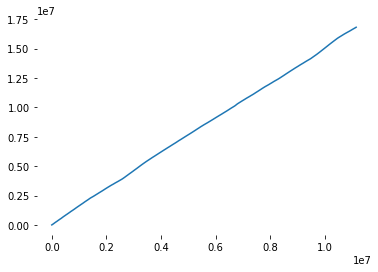

In [9]:
import numpy
import matplotlib.pyplot as plt

sums = numpy.cumsum(collisions)
plt.plot(range(len(collisions)), sums)
plt.box(False);

### Histogram of Probe Length

Number of failed probe attempts before an empty slot in the hash table was
found. Zero means that the first attempt, the "true" hash index value,
succeeded.

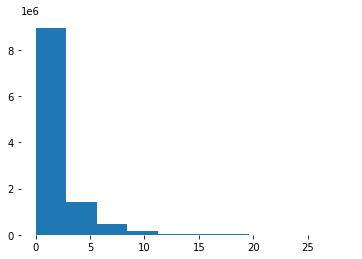

In [10]:
import matplotlib.pyplot as plt

plt.hist(collisions)
plt.box(False);
